## 导入库

In [1]:
import ttkbootstrap as ttk
from ttkbootstrap.constants import *
from tkinter.filedialog import askopenfilename
from ttkbootstrap.dialogs import Messagebox
import time
from PIL import Image, ImageTk
import os
import librosa
from sklearn.preprocessing import scale
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import metrics
from keras.preprocessing import image
from winsound import *
import csv

## 预函数定义

In [2]:
## ESC标签导入
esc_labels=['airplane','breathing','brushing_teeth','can_opening','car_horn','cat','chainsaw','chirping_birds','church_bells',
        'clapping','clock_alarm','clock_tick','coughing','cow','crackling_fire','crickets','crow','crying_baby','dog',
        'door_wood_creaks','door_wood_knock','drinking_sipping','engine','fireworks','footsteps','frog','glass_breaking',
        'hand_saw','helicopter','hen','insects','keyboard_typing','laughing','mouse_click','pig','pouring_water','rain',
        'rooster','sea_waves','sheep','siren','sneezing','snoring','thunderstorm','toilet_flush','train','vacuum_cleaner',
        'washing_machine','water_drops','wind']

esc_labels_ch=['飞机','呼吸','刷牙','开罐头','汽车喇叭','猫','电锯','啁啾鸟','教堂钟声',
        '鼓掌','时钟闹钟','时钟滴答','咳嗽','牛','噼里啪啦的火','蟋蟀','乌鸦','哭泣的婴儿','狗',
        '木门吱吱作响','敲木门','啜饮','引擎','烟花','脚步声','青蛙','玻璃破碎',
        '手锯','直升机','母鸡','昆虫','键盘打字','大笑','鼠标点击','猪','泼水','下雨',
        '公鸡','海浪','羊','警笛','打喷嚏','打鼾','雷暴','冲厕所','火车','吸尘器',
        '洗衣机','水滴','风']

engine_labels_ch=['损坏','良好','过载']

## 模型custom特征
def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

## 频谱图转换
def save_melspectrogram(file_name, file_path, sampling_rate=44100):
    """ Will save spectogram into current directory"""
    
    data, sr = librosa.load(file_path, sr=sampling_rate, mono=True)
    data = scale(data)

    melspec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
    # Convert to log scale (dB) using the peak power (max) as reference
        # per suggestion from Librbosa: https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html
    log_melspec = librosa.power_to_db(melspec, ref=np.max)  
    librosa.display.specshow(log_melspec, sr=sr)
    
    # create saving directory
    directory = './melspectrograms'
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    plt.savefig(directory + '/' + file_name.strip('.wav') + '.png')

## ENGINE预测
def predict_engine_label():
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)* 1./255
    preds = model_engine.predict(x)[0]
    
    max_index = np.argmax(np.array(preds))
    result = engine_labels_ch[max_index]

    return result

## ESC-50预测
def predict_esc_label():
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)* 1./255 
    preds = model_esc.predict(x)[0] #预测的n个概率值数组
    
    max_index = np.argmax(np.array(preds))
    result = esc_labels_ch[max_index]
    return result

## GUI函数定义

In [3]:
## 图片展示函数
def display():
    global img_path
    img_open = Image.open(img_path)
    img_open = img_open.resize((600, 400), Image.Resampling.LANCZOS)
    global img_png
    img_png = ImageTk.PhotoImage(img_open)
    label_img = ttk.Label(lf2, image = img_png)
    label_img.place(x=0,y=0,width=620,height=420)
    
## 音频播放函数
def play():
    # 变量全局化
    global path    
    # 获取音频路径
    path = askopenfilename()
    PlaySound(path, SND_FILENAME)

def save():
    global res_all
    global file_names

    data_list = []
    for a,b in zip(file_names,res_all):
        x = {}
        x['文件名']= a
        x['预测类别']= b
        data_list.append(x)
    # print(data_list)
 
    with open("result.csv",'a',newline='',encoding='GBK') as res_csv:
        writer = csv.writer(res_csv)
        for l in data_list:
            writer.writerow(l.values())
            
    msg2 = Messagebox.show_info(message="保存成功!")

## 通用识别函数
def button_common():
    time_now = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())) # 获取时间并格式化
    
    # 变量全局化
    global path
    global img_path
    global res_all
    global file_names
    
    # 获取音频路径
    path = askopenfilename()
    
    # 获取文件名
    file_name = path.split('/')[-1]
    file_names.append(file_name)
    if not path:
        return
    
    text.insert('insert',time_now + '\n') # 打印时间
    text.insert('insert','通用音频上传中...\n')
    text.insert('insert','音频预处理中...\n')
    
    # 频谱图转换
    save_melspectrogram(file_name, path)
    text.insert('insert','可视化处理中...\n')
    
    # 音频地址转频谱地址
    img_path=path.replace('test_data','melspectrograms')
    img_path=img_path.replace('wav','png')
    
    # 可视化函数调用
    display() 
    text.insert('insert','结果输出中...\n')
    
    # 模型预测
    res = predict_esc_label()
    res_all.append(res)
    
    # 预测值显示
    result_common.insert('insert', res)
    result_common.insert('insert', '\n')
    result_common.see(ttk.END)
    
    # 结束一轮
    text.insert('insert','\n')
    text.see(ttk.END) # 光标跟随着插入的内容移动

## 机房识别函数
def button_IDC():
    time_now = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())) # 获取时间并格式化
    
    # 变量全局化
    global path
    global img_path
    global res_all
    global file_names
    
    # 获取音频路径
    path = askopenfilename()
    
    # 获取文件名
    file_name = path.split('/')[-1]
    file_names.append(file_name)
    
    if not path:
        return
    
    text.insert('insert',time_now + '\n') # 打印时间
    text.insert('insert','机房音频上传中...\n')
    text.insert('insert','音频预处理中...\n')
    
    # 频谱图转换
    save_melspectrogram(file_name, path)
    text.insert('insert','可视化处理中...\n')
    
    # 音频地址转频谱地址
    img_path=path.replace('test_data','melspectrograms')
    img_path=img_path.replace('wav','png')
    
    # 可视化函数调用
    display() 
    text.insert('insert','结果输出中...\n')
    
    # 模型预测
    res = predict_engine_label()
    res_all.append(res)
    
    # 预测值显示
    result_IDC.insert('insert', res, res)
    result_IDC.insert('insert', '\n')
    result_IDC.see(ttk.END) 
    
    # 结束一轮
    text.insert('insert','\n')
    text.see(ttk.END) #光标跟随着插入的内容移动


## GUI界面设计

E:\Python\lib\site-packages\sklearn\preprocessing\_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


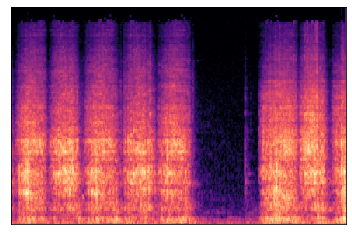

In [5]:
## 设置全局变量
img_png = None
path = "" # 音频文件路径
img_path = "" # 频谱图路径
res_all = [] # 预测结果列表
file_names = [] # 文件名列表

## 设置主窗口
root = ttk.Window(
    title="音频分类系统",
    size=(1024,768),
    resizable=None,
    )

## 加载模型
model_esc = load_model('./model/ESC50_94.h5', custom_objects={'top_5_accuracy': top_5_accuracy} )
model_engine = load_model('./model/ENGINE_99.h5', custom_objects={'top_5_accuracy': top_5_accuracy} )

## 加载模型缓冲时间
msg = Messagebox.show_info(message="检测模型加载中，请稍等")

## labelframe类
lf = ttk.Labelframe(text="上传模块",bootstyle=PRIMARY,width=100,height=60)
lf.place(x=40,y=40,width=150,height=450)

lf2 = ttk.Labelframe(text="可视化模块",bootstyle=SUCCESS,width=100,height=60)
lf2.place(x=200,y=40,width=600,height=450)

lf3 = ttk.Labelframe(text="结果模块",bootstyle=INFO,width=100,height=60)
lf3.place(x=810,y=40,width=150,height=450)

lf4 = ttk.Labelframe(text="信息提示工作台",bootstyle=WARNING,width=100,height=60)
lf4.place(x=10,y=500,width=1000,height=200)


## 设置上传模块按钮
b1 = ttk.Button(lf, text='通用音频识别', bootstyle=PRIMARY, command=button_common)
b1.place(x=10,y=180,width=130,height=40)

b2 = ttk.Button(lf, text='机房故障检测', bootstyle=(INFO,OUTLINE), command=button_IDC)
b2.place(x=10,y=320,width=130,height=40)

## 设置音频播放按钮
b3= ttk.Button(lf, text = '播放音频', bootstyle=SUCCESS, command = play)
b3.place(x=10,y=40,width=130,height=40)

## 设置结果模块

b4= ttk.Button(lf3, text = '保存结果', bootstyle=SUCCESS, command = save)
b4.place(x=10,y=40,width=130,height=40)

ttk.Label(lf3,text="通用分类结果",bootstyle=PRIMARY).place(x=10,y=100)
result_common = ttk.Text(lf3,width=10, height=20)
result_common.place(x=10,y=130,width=130,height=60)

ttk.Label(lf3,text="机房分类结果",bootstyle=INFO).place(x=10,y=200)
result_IDC = ttk.Text(lf3,width=10, height=20)
result_IDC.place(x=10,y=230,width=130,height=60)

## 设置机房音频结果标签
result_IDC.tag_config("损坏", background="yellow", foreground="red")
result_IDC.tag_config("过载", background="green", foreground="yellow")
result_IDC.tag_config("良好", foreground="green")

## 设置信息提示文本框
text = ttk.Text(lf4)
text.pack(padx=10,pady=10,fill=BOTH)

## 事件响应刷新
root.mainloop()